# Prévision du prix de l’électricité – Notebook de l’expert

Ce notebook présente une solution complète pour le ChallengeData d’Elmy portant sur la prédiction du prix de l’électricité. Nous détaillons chaque étape du processus : chargement des données, analyse exploratoire, préparation du jeu de données, entraînement d’un modèle de classification (XGBoost) et génération des prédictions. Le code est commenté en français et modulaire, prêt à l’emploi dans un Jupyter Notebook classique. Les bibliothèques utilisées incluent pandas, numpy, seaborn, matplotlib, xgboost, scikit-learn et openpyxl.

## 1. Chargement des données

On commence par importer les bibliothèques nécessaires et charger les fichiers Excel fournis. Nous vérifions ensuite la taille des données chargées (nombre de lignes et colonnes) pour chaque jeu de données (X_train, Y_train, X_test, Y_random).


In [221]:
# Import des bibliothèques principales

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


# Chargement des fichiers Excel (X_train, Y_train, X_test, Y_random)

X_train = pd.read_csv('data/X_train_Wwou3IE.csv')
Y_train = pd.read_csv('data/y_train_jJtXgMX.csv')
X_test = pd.read_csv('data/X_test_GgyECq8.csv')
Y_random = pd.read_csv('data/y_random_pt8afo8.csv')

# Aperçu des dimensions des jeux de données
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_random shape:", Y_random.shape)


X_train shape: (10605, 10)
Y_train shape: (10605, 2)
X_test shape: (4942, 10)
Y_random shape: (4942, 2)


## 2 Analyse exploratoire des données
Nous explorons les données pour mieux les comprendre. On examine les types de variables, la présence de valeurs manquantes, et des statistiques descriptives. On regarde également les corrélations entre variables numériques. Enfin, on étudie la distribution de la variable cible d’origine spot_id_delta dans Y_train.

### 2.1 Aperçu des types et de l'échantillon de données

In [222]:
print("Types de variables X_train :\n", X_train.dtypes)
print("\nAperçu de X_train :")
display(X_train.head())

print("\nTypes de variables Y_train :\n", Y_train.dtypes)
print("\nAperçu de Y_train :")
display(Y_train.head())

Types de variables X_train :
 DELIVERY_START                    object
load_forecast                    float64
coal_power_available             float64
gas_power_available              float64
nucelear_power_available         float64
wind_power_forecasts_average     float64
solar_power_forecasts_average    float64
wind_power_forecasts_std         float64
solar_power_forecasts_std        float64
predicted_spot_price             float64
dtype: object

Aperçu de X_train :


,DELIVERY_START,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price
0,2022-01-01 02:00:00+01:00,49439.0,3386.0,11487.0,44118.0,3035.0,0.0,79.248348,0.0,NaN
1,2022-01-01 03:00:00+01:00,46511.0,3386.0,11487.0,44118.0,3143.0,0.0,61.776532,0.0,NaN
2,2022-01-01 04:00:00+01:00,45158.0,3386.0,11487.0,44118.0,3288.0,0.0,44.291112,0.0,NaN
3,2022-01-01 05:00:00+01:00,44779.0,3386.0,11487.0,44118.0,3447.0,0.0,36.127588,0.0,NaN
4,2022-01-01 06:00:00+01:00,45284.0,3386.0,11487.0,44118.0,3679.0,0.0,30.983023,0.0,NaN



Types de variables Y_train :
 DELIVERY_START     object
spot_id_delta     float64
dtype: object

Aperçu de Y_train :


,DELIVERY_START,spot_id_delta
0,2022-01-01 02:00:00+01:00,-36.874770
1,2022-01-01 03:00:00+01:00,-12.643588
2,2022-01-01 04:00:00+01:00,-1.950193
3,2022-01-01 05:00:00+01:00,1.938272
4,2022-01-01 06:00:00+01:00,0.199907


### 2.2 Recherche de valeurs manquantes dans X_train


Valeurs manquantes par colonne dans X_train :
load_forecast                    1287
coal_power_available                1
gas_power_available                 1
nucelear_power_available            1
wind_power_forecasts_average       24
solar_power_forecasts_average      24
wind_power_forecasts_std           24
solar_power_forecasts_std          24
predicted_spot_price             8759
dtype: int64


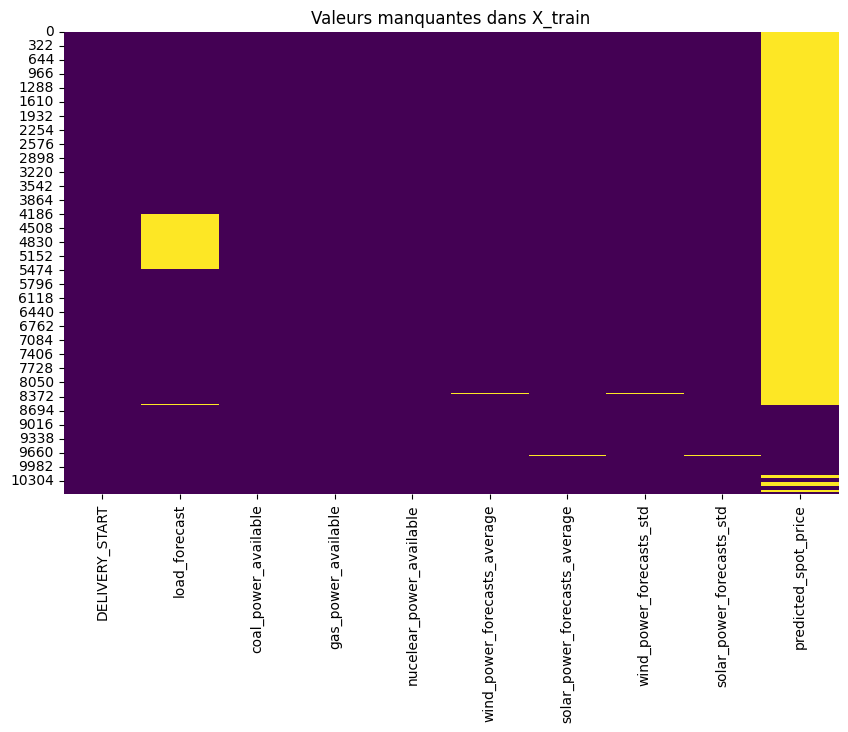

In [223]:
missing_values = X_train.isnull().sum()
print("\nValeurs manquantes par colonne dans X_train :")
print(missing_values[missing_values > 0])

# Visualisation des valeurs manquantes
plt.figure(figsize=(10,6))
sns.heatmap(X_train.isnull(), cbar=False, cmap="viridis")
plt.title("Valeurs manquantes dans X_train")
plt.show()

On remarque des valeurs manquantes. Certaines colonnes ont peu de valeurs manquantes, comme coal_power_available, gas_power_available, wind_power_forecasts_average, solar_power_forecasts_average, et nuclear_power_available. Dans ce cas, nous choisissons d'imputer ces valeurs avec la moyennen ou la médiane. 
La colonne predicted_spot_price a 8759 valeurs manquantes. Cela représente une grande proportion de données absentes. Il serait préférable de supprimer cette colonne.

In [224]:


# Supprimer les colonnes avec trop de valeurs manquantes (par exemple predicted_spot_price)
X_train.drop(columns=['predicted_spot_price'], inplace=True)
X_test.drop(columns=['predicted_spot_price'], inplace=True)

# Supprimer les lignes avec des valeurs manquantes 
X_train = X_train.dropna()
Y_train = Y_train.loc[X_train.index]  # on garde les mêmes index


### 2.3 Analyses générales des covariables

#### 2.3.1 Distribution de la consommation éléctrique prévue

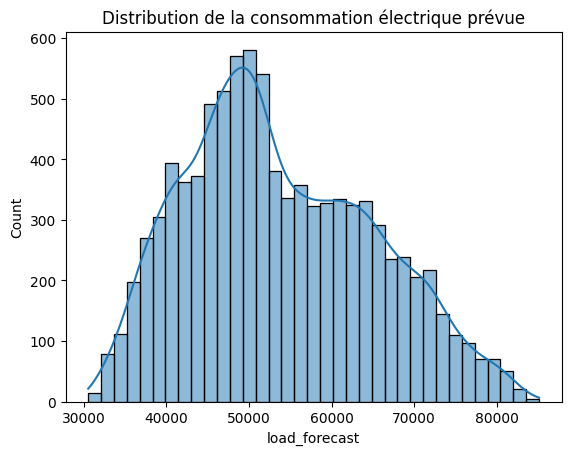

In [225]:
sns.histplot(X_train['load_forecast'], kde=True)
plt.title("Distribution de la consommation électrique prévue")
plt.show()


#### 2.3.2 Statistiques descriptives sur X_train

In [226]:
print("\nStatistiques descriptives de X_train :")
display(X_train.describe())


Statistiques descriptives de X_train :


,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std
count,9269.000000,9269.000000,9269.000000,9269.000000,9269.000000,9269.00000,9269.000000,9269.000000
mean,53731.188909,2899.290538,11508.902578,36473.802244,4785.857806,1746.54569,131.719805,24.793742
std,11295.869364,472.744409,487.342953,7430.717961,3449.159216,2511.99797,137.355037,41.668033
min,30515.000000,1646.000000,9769.000000,22285.000000,592.000000,0.00000,1.830211,0.000000
25%,45314.000000,2226.000000,11140.000000,30071.000000,2172.000000,0.00000,49.414083,0.000000
50%,51848.000000,2806.000000,11549.000000,34795.000000,3565.000000,93.00000,91.131246,2.799093
75%,62118.000000,3386.000000,11945.000000,43406.000000,6505.000000,3205.00000,163.429037,35.346834
max,85145.000000,3386.000000,11963.000000,50122.000000,15167.000000,9985.00000,1871.571992,368.419045


#### 2.3.3 Corrélation entre variables numériques (X_train + Y_train)


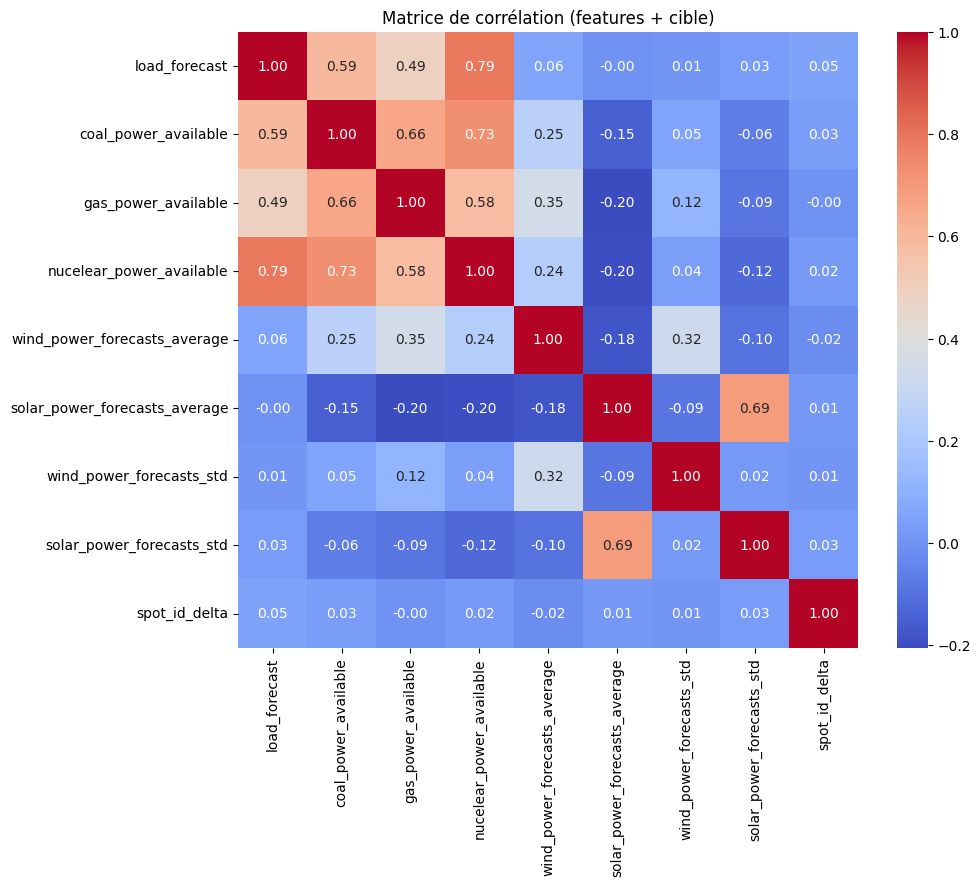

In [227]:
data_numeric = pd.concat([X_train, Y_train], axis=1).select_dtypes(include=['number'])
corr_matrix = data_numeric.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Matrice de corrélation (features + cible)")
plt.show()


#### 2.3.4 Nuage de points entre une variable explicative et sa cible

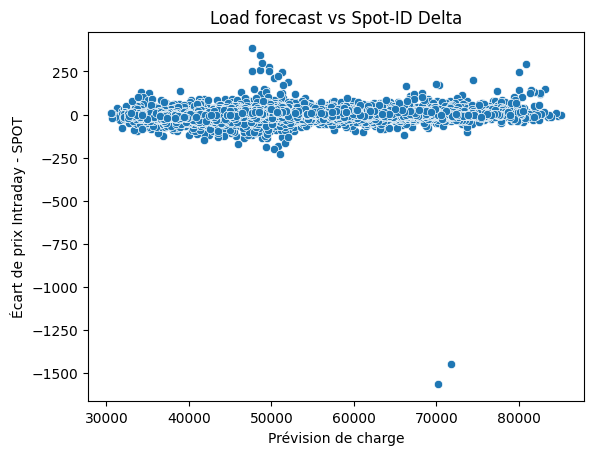

In [228]:
Y_train_bis = Y_train['spot_id_delta']


sns.scatterplot(x=X_train['load_forecast'], y=Y_train_bis)
plt.title("Load forecast vs Spot-ID Delta")
plt.xlabel("Prévision de charge")
plt.ylabel("Écart de prix Intraday - SPOT")
plt.show()

On remarque deux données particulièrement éloignées du nuage principal. Ces données ne sont aps nécessairement fausses mais sont atypiques. On choisit donc, pour une prévision plus réalise, d'ignorer ces dernières.

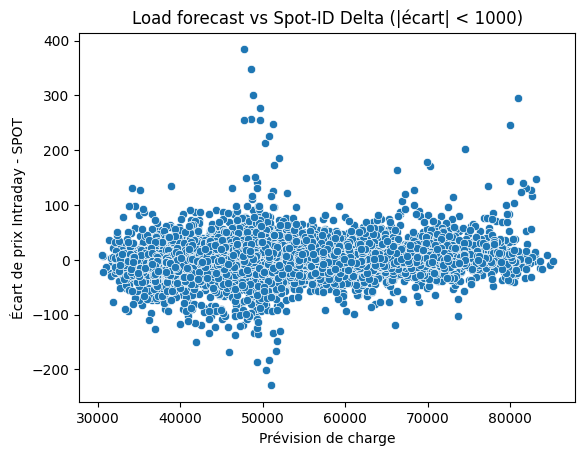

In [229]:
#Création d'un masque de filtrage
mask = Y_train_bis.abs() < 1000

# Filtrage des deux variables pour ne garder que les valeurs valides
filtered_X = X_train[mask]
filtered_Y = Y_train_bis[mask]

# Affichage du nuage de points
sns.scatterplot(x=filtered_X['load_forecast'], y=filtered_Y)
plt.title("Load forecast vs Spot-ID Delta (|écart| < 1000)")
plt.xlabel("Prévision de charge")
plt.ylabel("Écart de prix Intraday - SPOT")
plt.show()

On aimerait voir plus précisément le nuage principal et donc on visualise avec un filtre plus précis limitant la valeur absaloue de l'écart à 400.

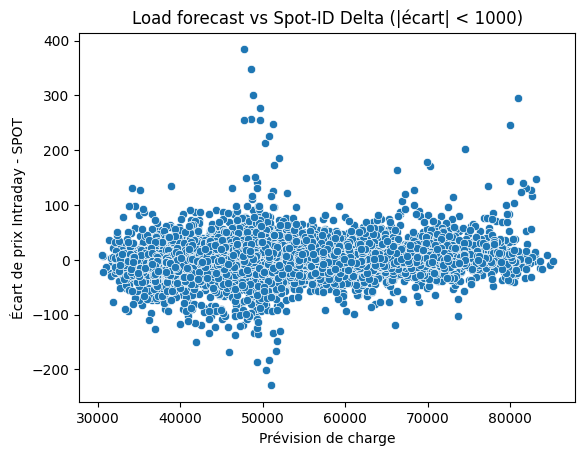

In [230]:
#Création d'un masque de filtrage
mask = Y_train_bis.abs() < 400

# Filtrage des deux variables pour ne garder que les valeurs valides
filtered_X = X_train[mask]
filtered_Y = Y_train_bis[mask]

# Affichage du nuage de points
sns.scatterplot(x=filtered_X['load_forecast'], y=filtered_Y)
plt.title("Load forecast vs Spot-ID Delta (|écart| < 1000)")
plt.xlabel("Prévision de charge")
plt.ylabel("Écart de prix Intraday - SPOT")
plt.show()

Ensuite, on examine spécifiquement la distribution de la variable cible d’origine spot_id_delta, afin de voir par exemple si elle suit une loi normale ou si elle est centrée autour de zéro.

### 2.4 Analyse de la variable cible 

#### 2.4.1 Distribution de la variable cible continue spot_id_delta


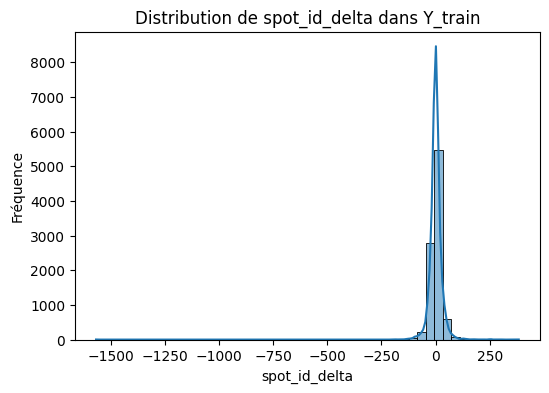

In [231]:
plt.figure(figsize=(6,4))
sns.histplot(Y_train['spot_id_delta'], bins=50, kde=True)
plt.title("Distribution de spot_id_delta dans Y_train")
plt.xlabel("spot_id_delta")
plt.ylabel("Fréquence")
plt.show()

On remarque que la distribution est centrée autour de 0, ainsi l'écart de prix est quasiment autant de fois positif que négatif dans nos données.

## 3. Prétraitement des données

### 3.1 Encodage de la date

La colonne DELIVERY_START contient une date/heure. Nous convertissons cette colonne au format datetime et en extrayons des caractéristiques utiles, comme l’heure de la journée (hour) et le jour de la semaine (dayofweek). Nous pourrons ainsi intégrer l’effet temporel dans le modèle. Après extraction, on peut supprimer la colonne originale DELIVERY_START si elle n’apporte pas d’information supplémentaire.

In [232]:
def encoder_dates(df):
    """
    Convertit la colonne DELIVERY_START en datetime UTC et en extrait les composantes heure et jour de la semaine.
    La colonne originale DELIVERY_START est ensuite supprimée.
    """
    # Conversion en datetime (timezone-aware vers UTC standard)
    df['DELIVERY_START'] = pd.to_datetime(df['DELIVERY_START'], utc=True)
    
    # Extraction de l'heure et du jour de la semaine (UTC)
    df['hour'] = df['DELIVERY_START'].dt.hour
    df['weekday'] = df['DELIVERY_START'].dt.weekday  # lundi = 0

    # Suppression de la colonne initiale
    df = df.drop(columns=['DELIVERY_START'])

    return df

On applique l'encodage de la date sur X_train et X_test.

In [233]:
X_train = encoder_dates(X_train)
X_test = encoder_dates(X_test)
print("Colonnes X_train après encodage des dates :", X_train.columns.tolist())

Colonnes X_train après encodage des dates : ['load_forecast', 'coal_power_available', 'gas_power_available', 'nucelear_power_available', 'wind_power_forecasts_average', 'solar_power_forecasts_average', 'wind_power_forecasts_std', 'solar_power_forecasts_std', 'hour', 'weekday']


### 3.2 Transformation de la cible en variable binaire

La variable cible spot_id_delta est transformée en variable binaire spot_id_delta_binary : elle vaut 1 si spot_id_delta est positif (supérieur à 0), et 0 sinon (négatif ou zéro). On ajoute cette colonne à Y_train et vérifie l’équilibre des classes.

#### 3.2.1 Création d'une cible binaire 

On choisit de passer notre variable quantitative (écart de prix) en une variable qualitative (positif ou négatif). Ainsi Y vaut 1 si spot_id_delta > 0, 0 sinon.


In [234]:
Y_train['spot_id_delta_binary'] = (Y_train['spot_id_delta'] > 0).astype(int)


#### 3.2.2 Vérification de la répartition des classes


On vérifie que les classes sont équitablement réparties : à peu près autant de 0 et que 1.

Répartition des classes (0 vs 1) :
spot_id_delta_binary
1    4695
0    4574
Name: count, dtype: int64


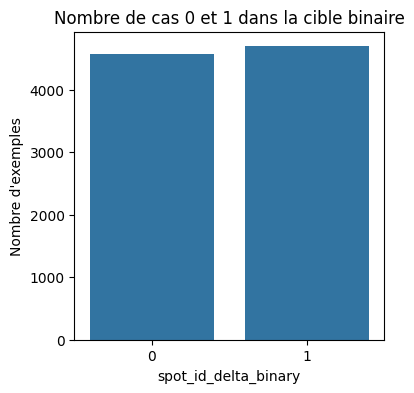

In [235]:
counts = Y_train['spot_id_delta_binary'].value_counts()
print("Répartition des classes (0 vs 1) :")
print(counts)
plt.figure(figsize=(4,4))
sns.countplot(x='spot_id_delta_binary', data=Y_train)
plt.title("Nombre de cas 0 et 1 dans la cible binaire")
plt.xlabel("spot_id_delta_binary")
plt.ylabel("Nombre d'exemples")
plt.show()


Cette transformation fait de notre problème un problème de classification binaire. On constate ainsi la proportion d’exemples positifs et négatifs.

### 3.3 Séparation en jeu d’entraînement et de validation

Nous séparons ensuite le jeu X_train prétraité et la cible binaire Y_train['spot_id_delta_binary'] en un sous-jeu d’entraînement (X_train_sub, y_train_sub) et un sous-jeu de validation (X_val, y_val). Cela nous permettra d’évaluer le modèle sur des données non vues pendant l’entraînement. Ici, on utilise par exemple 80% pour l’entraînement et 20% pour la validation.

In [236]:
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, Y_train['spot_id_delta_binary'], test_size=0.2, random_state=42
)

print("Forme de X_train_sub :", X_train_sub.shape)
print("Forme de X_val :", X_val.shape)
print("Forme de y_train_sub :", y_train_sub.shape)
print("Forme de y_val :", y_val.shape)

Forme de X_train_sub : (7415, 10)
Forme de X_val : (1854, 10)
Forme de y_train_sub : (7415,)
Forme de y_val : (1854,)


## 5. Entraînement du modèle de classification (XGBoost)

Nous entraînons un modèle de XGBoost pour la classification binaire. XGBoost est bien adapté aux données tabulaires et gère les interactions entre les variables. On crée un classifieur XGBClassifier de base et on l’ajuste sur nos données d’entraînement. On peut spécifier random_state pour la reproductibilité et éventuellement régler d’autres hyperparamètres (nombre d’arbres, profondeur, etc.), mais nous prenons les valeurs par défaut pour cette démonstration.

### 5.1 Création et entraînement du classifieur XGBoost


In [237]:
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train_sub, y_train_sub)

c:\Users\julie\OneDrive - CentraleSupelec\casablanca\COURS\ML\PROJET LIL\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:45:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

### 5.2 Prédiction sur le jeu de validation


In [238]:
y_pred_val = xgb_clf.predict(X_val)
print("Prédiction effectuée sur le jeu de validation.")

Prédiction effectuée sur le jeu de validation.


## 6. Évaluation avec la métrique Weighted Accuracy

La métrique d’évaluation du challenge est la Weighted Accuracy. Nous définissons une fonction personnalisée weighted_accuracy qui calcule ce score. Par convention, on peut pondérer davantage la classe positive (valeur 1) pour compenser un éventuel déséquilibre. Par exemple, on utilise ici un poids w=5 sur la classe positive :
$$
\text{Weighted Accuracy} = \frac{\text{WTP} + \text{WTN}}{\text{WTP} + \text{WTN} + \text{WFP} + \text{WFN}}
$$

avec :
- WTP = somme des $|y_i|$ pour les vrais positifs,
- WTN = somme des $|y_i|$ pour les vrais négatifs,
- WFP = somme des $|y_i|$ pour les faux positifs,
- WFN = somme des $|y_i|$ pour les faux négatifs. est vraie et 0 sinon,



In [239]:
def weighted_accuracy(y_true, y_pred, weight=1):
    """
    Calcule la Weighted Accuracy :
    (w * TP + TN) / (w * (TP + FN) + (TN + FP))
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    wa = (weight * tp + tn) / (weight * (tp + fn) + (tn + fp))
    return wa

### 6.1 Calcul du score sur la validation


In [240]:
wa_score = weighted_accuracy(y_val, y_pred_val, weight=5)
print(f"Weighted Accuracy sur le jeu de validation : {wa_score:.4f}")

Weighted Accuracy sur le jeu de validation : 0.7407


On affiche également la matrice de confusion et d’autres métriques classiques pour comprendre les performances :


### 6.2 Matrice de confusion


Matrice de confusion (validation) :


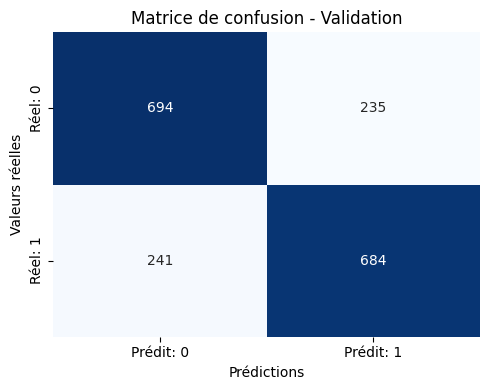

In [247]:
from sklearn.metrics import classification_report, accuracy_score

cm = confusion_matrix(y_val, y_pred_val)
print("Matrice de confusion (validation) :")


# Affichage graphique
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Prédit: 0", "Prédit: 1"],
            yticklabels=["Réel: 0", "Réel: 1"])
plt.title("Matrice de confusion - Validation")
plt.xlabel("Prédictions")
plt.ylabel("Valeurs réelles")
plt.tight_layout()
plt.show()

### 6.3 Rapport de classification standard


In [248]:
print("\nRapport de classification :")
print(classification_report(y_val, y_pred_val, target_names=['Classe 0', 'Classe 1']))
print("Accuracy simple :", accuracy_score(y_val, y_pred_val))


Rapport de classification :
              precision    recall  f1-score   support

    Classe 0       0.74      0.75      0.74       929
    Classe 1       0.74      0.74      0.74       925

    accuracy                           0.74      1854
   macro avg       0.74      0.74      0.74      1854
weighted avg       0.74      0.74      0.74      1854

Accuracy simple : 0.7432578209277239


## 7. Prédictions finales sur X_test

Après évaluation satisfaisante, on applique le même prétraitement à X_test (encodage des dates déjà fait) et on utilise le modèle entraîné pour prédire la classe binaire sur les nouvelles données.

### 7.1 Prédiction sur X_test (après prétraitement des dates)


In [249]:
X_test = X_test[X_train.columns]

y_test_pred = xgb_clf.predict(X_test)
print("Prédictions finalisées sur X_test.")

Prédictions finalisées sur X_test.


### 7.2. Création du fichier de soumission

Enfin, on prépare le fichier de soumission ma_submission.csv avec deux colonnes : Id et prediction. On utilise la colonne Id de X_test (ou l’index si aucune colonne Id n’est présente) et la prédiction binaire correspondante. On enregistre le fichier au format CSV sans index supplémentaire.

In [250]:
# Construction du DataFrame de soumission

if 'Id' in X_test.columns:
    submission = pd.DataFrame({
        'Id': X_test['Id'],
        'prediction': y_test_pred
    })
else:
    submission = pd.DataFrame({
        'Id': X_test.index,
        'prediction': y_test_pred
    })

# Sauvegarde au format CSV
submission.to_csv('ma_submission.csv', index=False)
print("Fichier de soumission 'ma_submission.csv' créé avec succès.")

Fichier de soumission 'ma_submission.csv' créé avec succès.



Le fichier ma_submission.csv contient ainsi, pour chaque identifiant, la prédiction binaire (0 ou 1) correspondant à notre modèle.
Ce notebook fournit un pipeline complet, depuis le chargement des données jusqu’à l’enregistrement des prédictions. Les commentaires et les explications détaillées facilitent la compréhension du flux de travail, et le code est structuré en sections claires pour être facilement reproductible dans un environnement Jupyter.